<h1 style="border-width:2px; border-style:solid; border-color:blue; background-color:#367395; text-align: center; text-shadow: 0px 0px 3px red; padding-bottom: 2em; padding-top: 1em;">Project:<br>Machine Learning Regression for Prices Optimization</h1>

### 6º HACKDAY - COMUNIDADE DS - 21.22/10/2023

The event consisted of a machine learning competition where teams were presented with a business problem and had to find the best possible solution in less than 48 hours. This code is based on the solution developed by the "May the Data Be With You" Team, which won **1st place** in the competition, with a SMAPE percentage error of 9.11%.

After the competition ended, we used the code as a laboratory and conducted additional studies, mainly in the FEATURE ENGINEERING stage. In the end, we were able to reduce the SMAPE error to 8.2%.

See the results of the competition in:
https://www.kaggle.com/competitions/product-price-predicition-20/leaderboard

### 'May The Data Be With You' Team
- Edilson Santos
- Aroldo Brancalhão
- Leonardo Rose
- Manoel Mendonça
- M. Alessandro Fonseca

---

# Problema de Negócio

A empresa Dados & Decotes atua em e-commerce no ramo de moda masculina e feminina com roupas, calçados e acessórios. O desafio atual da varejista é otimizar os preços dos seus produtos de modo a maximizar o lucro nas vendas.

O atual sistema de precificação de produtos tem duas etapas. Primeiro é colocada margem fixa de lucro sobre o preço de custo do produto. Na segunda etapa, após 3 meses de avaliação do comportamento das vendas, os preços são ajustados de acordo com as quantidades demandadas de cada produto.

Na terceira etapa de precificação, a ser implantada com base no resultado dos estudos de nossa Equipe de Cientistas de Dados, os preços dos produtos novos e recém lançados no mercado serão otimizado com base nas suas características, tais como marca, categoria, tecido e outras.



## Objetivo

Como analistas e cientistas de dados da Dados & Decotes, o desafio da equipe é encontrar quais deveriam ser estes novos preços, com base neste conjunto histórico de dados contendo os preços e as características dos produtos que alcançaram o maior sucesso nas vendas decorrente dos cálculos de elasticidade de preço.

No presente trabalho, as seguintes ferramentas foram utilizadas:

- Modelo Utilizado - Random Forest
- Métrica - SMAPE - Resultado: 9.11% e 8.20%

<i>SMAPE: Symmetric Mean Absolute Percentage Error</i>

<a id='0'></a>
# 0. PROCEDIMENTOS INICIAIS

## 0.1 Importação de Bibliotecas

In [44]:
import ast
import optuna
import inflection
import warnings
import re

import pandas                                             as pd
import numpy                                              as np
import matplotlib.pyplot                                  as plt
import seaborn                                            as sns
import sklearn.cluster                                    as ct
import sklearn.metrics                                    as mt

from sklearn.preprocessing                                import TargetEncoder
from sklearn.model_selection                              import train_test_split

from sklearn.metrics                                      import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error 
from sklearn.ensemble                                     import RandomForestRegressor, VotingRegressor
from sklearn.linear_model                                 import LinearRegression
from xgboost                                              import XGBRegressor
from catboost                                             import CatBoostRegressor
from lightgbm                                             import LGBMRegressor

from scipy.stats                                          import chi2_contingency

from locale                                               import atof, atoi, setlocale, LC_NUMERIC
from wordcloud                                            import WordCloud

plt.style.use('ggplot')
sns.set_style('darkgrid')

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

warnings.filterwarnings('ignore')

## 0.2 Funções Auxiliares

### Coletânea de Funções

In [2]:
#---------- Converte todas as KEYs para maiúsculas.
def newDict( inDict ):
    lista = list()
    for item in inDict:
        for key in item:
            item2 = {}
            item2[ key.upper() ] = item[key]
            lista.append( item2 )
    return lista

#---------- Função Customizada da Métrica SMAPE
def smape(y_pred, y_test):

    smape = 100 / len(y_test) * np.sum(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred)))
    return smape

#---------- Função para computar todas as metricas
def compute_metrics(model_name, y_pred, y_test):

    y_pred = np.expm1(y_pred)
    y_test = np.expm1(y_test)
                     

    smape = 100 / len(y_test) * np.sum(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred)))
    mae =mean_absolute_error(y_pred, y_test)
    mape = mean_absolute_percentage_error(y_pred, y_test)
    rmse = mean_squared_error(y_pred, y_test, squared=False)

    df = pd.DataFrame({
        'Model':model_name,
        'MAE':mae,
        'MAPE':mape,
        'RMSE':rmse,
        'SMAPE':smape
    }, index=[0])

    return df

#---------- Função para montar a submissão
def make_submission(X_test_2, y_pred_test):

    path = 'http://menezes.mendonca.nom.br/datasets/hackday6_cds/test.json'
    test_raw = pd.read_json(path, orient='split')
    X_test_submission = X_test_2.copy()
    X_test_submission['pid'] = test_raw['pid']
    X_test_submission['actual_price'] = y_pred_test
    df_submission = X_test_submission[['pid','actual_price']]

    return df_submission

#---------- Função para analisar Correlação de features categóricas
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

#---------- Função para conversão de SIZE para valores numéricos
def Convert_Size( inSize, ZeroValue ):
    # International General US Size Chart:
    #
    #  XXS - 34 - extra extra small
    #   XS - 36 - extra small
    #    S - 38 - small
    #    M - 40 - medium
    #    L - 42 - large
    #   XL - 44 - extra large
    #  XXL - 46 - extra extra large
    #  3XL - 48 - 3x extra large
    #  4XL - 50 - 4x extra large
    #  5XL - 52 - 5x extra large
    #
    # OUTROS VALORES:
    #         0 - 40 - medium (é o que mais ocorre: testar qual valor é melhor, tipo, 40 ou 38 ou 42)
    #      free - 40 - medium
    #        38 - 38 - small
    #        40 - 40 - medium
    #    medium - 40 - medium
    # 5-6 years - 32 - 3XS
    #..............................
    sz = str(inSize).upper()
    if sz == "XXS":
        return 34
    elif sz == "XS":
        return 36
    elif sz == "S" or sz == "38":
        return 38
    elif sz == "M" or sz == "MEDIUM" or sz == "40" or sz =="FREE":
        return 40
    elif sz == "L":
        return 42
    elif sz == "XL":
        return 44
    elif sz == "XXL":
        return 46
    elif sz == "3XL":
        return 48
    elif sz == "4XL":
        return 50
    elif sz == "5XL":
        return 52
    elif sz == "5-6 YEARS":
        return 32
    elif sz == "0":
        return ZeroValue
    else:
        return ZeroValue

#---------- Lê coluna "inCol", extrai palavras e salva em "inSet"
def add_word_to_setlist(inSet: set, inDF, inCol: str) -> set:
    # Define uma lista de stopwords para exclusão
    stopwords = {'the', 'you', 'your', 'with', 'and', 'are', 'for', 
                 'his', 'her', 'our', 'ours', 'this', 'able', 'from', 'fro', 
                 'all', 'undefined', 'was', 'that', 'very', 'use', 'any', 
                 'can', 'every', 'which', 'but', 'even', 'has', 'keep', 
                 'off', 'self', 'sure', 'user', 'will', 'etc', 'get', 'its', 
                 'one', 'two', 'three', 'four', 'last', 'nan', 'doesn', 'ltd', 
                 'total'}

    # Cria coluna temporária e realiza operações de limpeza de texto vetorizadas
    inDF['temp'] = ( inDF[inCol]
                        .str.lower()
                        .str.replace("-", "", regex=True)
                        .str.replace(r"\W+", " ", regex=True)
                        .str.strip()
                   )

    # Extração de palavras, filtrando stopwords, palavras curtas e numéricas
    words = inDF['temp'].str.split(expand=True).stack()  # Cria uma série de palavras
    words = words[words.str.len() >= 3]  # Filtra palavras por tamanho
    words = words[~words.str.isnumeric()]  # Exclui palavras que são numéricas
    words = words[~words.isin(stopwords)]  # Exclui stopwords

    # Atualiza o conjunto com palavras filtradas
    inSet.update(words.unique())

    # Remove a coluna temporária
    inDF.drop('temp', axis=1, inplace=True)

    # Retorna o conjunto atualizado
    return inSet


def add_word_to_setlist_old(inSet: set, inDF, inCol: str) -> set:

    # cria coluna temporária e coloca o texto a ser tratado
    inDF['temp'] = ( inDF[inCol]
                        .str.lower()
                        .str.replace("-", "", regex=True)
                        .str.replace(r"\W+", " ", regex=True)
                        .str.strip()
                    )

    # Cria coleção de palavras
    for txt in inDF['temp']:
        for item in txt.split():
            if len(item) < 3 or item.isnumeric():
                continue
            if item in ['the', 'you', 'your', 'with', 'and', 'are', 'for', 
                        'his', 'her', 'our', 'ours', 'this', 'able', 'from', 'fro', 
                        'all', 'undefined', 'was', 'that', 'very', 'use', 'any', 
                        'can', 'every', 'which', 'but', 'even', 'has', 'keep', 
                        'off', 'self', 'sure', 'user', 'will', 'etc', 'get', 'its', 
                        'one', 'two', 'three', 'four', 'last', 'nan', 'doesn', 'ltd',
                        'total']:
                continue
            inSet.add(item)

    inDF = inDF.drop('temp', axis=1)

    # Fim: retorna coleção atualizada
    return inSet

#---------- Converte Texto para Features
def Pre27_Text2Features( inDF, inModeloDF ):

    # Lista de colunas a serem analisadas:
    Cols = ['title', 'description', 'OTHER DETAILS', 'seller', 'category', 'sub_category', 
            'FABRIC CARE', 'FABRIC', 'GENERIC NAME', 'COLOR', 'SECONDARY COLOR', 
            'BRAND COLOR', 'BRAND FIT', 'CLOSURE', 'FIT', 'IDEAL FOR',
            'MODEL NAME', 'NECK', 'NECK TYPE', 'OCCASION', 'PATTERN', 'SALES PACKAGE',
            'SECONDARY COLOR', 'SLEEVE', 'TYPE', 'SUITABLE FOR'
           ]

    Cols = ['title', 'description', 'OTHER DETAILS', 'seller', 'category', 'sub_category', 
            'FABRIC CARE', 'FABRIC', 'GENERIC NAME', 'COLOR', 'SECONDARY COLOR'
           ]

    # Listar features de texto existentes em "inModeloDF"
    NewFeatures = inModeloDF.columns.values.tolist()
    NewFeatures = [ i for i in NewFeatures if i.find("txt_")==0 ]

    # Para cada "NewFeature", cria uma coluna no dataframe (inicia = False)
    for i in range( len(NewFeatures) ):
        inDF[NewFeatures[i]] = False

    # Para cada palavra (em NewFeature), busca em cada linha do DF,
    # ...nas colunas selecionadas, e anota se ocorrer a palavra
    i = 0
    for p in range( len(NewFeatures) ):
        plv = NewFeatures[p][4:]
        i += 1
        if i>10:
            i = 0
            print(p, end=" ")
        for lnh in range( len(inDF) ):
            for col in Cols:
                if str(inDF.loc[lnh, col]).find(plv)>-1:
                    inDF.loc[lnh, "txt_"+plv] = True
                    break
    print("ok")


### Função para montar dados de TESTE

In [3]:
#Função para aplicar todas as limpezas nos dados de TESTE
def clean_test( X_test_2, onehot, te, inModeloX ):

    # 2.1. Feature Eng: contar número de produtos
    X_test_2['product_details_count'] = X_test_2['product_details'].apply(lambda x: len(ast.literal_eval(x)) )
    # 2.1. Feature Eng: detalhes -> colunas
    X_test_2['product_details'] = X_test_2['product_details'].str.lower()
    X_test_2['product_details'] = X_test_2['product_details'].apply(lambda x: ast.literal_eval(x))
    X_test_2['product_details'] = X_test_2['product_details'].apply(lambda x: newDict(x))
    
    # 2.1. Feature Eng: busca todas as chaves
    all_keys = set()
    for data in X_test_2['product_details']:
        for item in data:
            if len( str(item.keys()) ) < 17:  # evita KEY='' ou =' '
                continue
            all_keys.update(item.keys())
    
    for key in all_keys:
        X_test_2[key] = X_test_2['product_details'].apply(lambda x: next((item[key] for item in x if key in item), np.nan))
    
    X_test_2.drop('product_details', axis=1, inplace=True)

    # 2.1. Feature Eng: selecionar as melhores colunas
    details_to_maintain_test = ['pid', '_id',
                       'average_rating',
                       'number_of_reviews',
                       'brand',
                       'category',
                       'crawled_at',
                       'description',
                       'images',
                       'out_of_stock',
                       'avg_delivery_time_days',
                       'seller',
                       'sub_category',
                       'fabrication_time',
                       'title',
                       'product_details_count',
                        "BRAND COLOR",
                        "BRAND FIT",
                        "CLOSURE",
                        "COUNTRY OF ORIGIN",
                        "COLOR",
                        "FABRIC",
                        "FABRIC CARE",
                        "FIT",
                        "GENERIC NAME",
                        "HOODED",
                        "IDEAL FOR",
                        "MODEL NAME",
                        "NECK",
                        "NECK TYPE",
                        "NUMBER OF CONTENTS IN SALES PACKAGE",
                        "OCCASION",
                        "OTHER DETAILS",
                        "PACK OF",
                        "PATTERN",
                        "POCKETS",
                        "REVERSIBLE",
                        "SALES PACKAGE",
                        "SECONDARY COLOR",
                        "SLEEVE",
                        "SLEEVE TYPE",
                        "SIZE",
                        "STYLE CODE",
                        "SUITABLE FOR",
                        "TYPE"
                        ]
    X_test_2 = X_test_2[details_to_maintain_test]

    # 2.2. Feature Eng: criar coluna "número de imagens"
    X_test_2['images'] = X_test_2['images'].apply(lambda x: ast.literal_eval(x))
    X_test_2['number_images'] = X_test_2['images'].apply(lambda x: len(x))

    # 2.3. Feature Eng: Coluna Fabric
    X_test_2['has_cotton']    = X_test_2['FABRIC'].str.contains('cott', case=False, na=False)
    X_test_2['has_polyester'] = X_test_2['FABRIC'].str.contains('poly', case=False, na=False)
    X_test_2['has_lycra']     = X_test_2['FABRIC'].str.contains('lycr', case=False, na=False)
    
    # 2.3. Feature Eng: Coluna Brand Fit
    X_test_2['is_regular'] = X_test_2['BRAND FIT'].str.contains('reg', case=False, na=False)
    X_test_2['is_slim']    = X_test_2['BRAND FIT'].str.contains('slim', case=False, na=False)
    X_test_2['is_fit']     = X_test_2['BRAND FIT'].str.contains('fit', case=False, na=False)

    # 2.4. Feature Eng: Preencher NaNs
    X_test_2 = X_test_2.fillna(0)

    # 2.5. Juntar Variáveis "pack of" e "number of contents in sales package"
    # 'PACK OF'
    X_test_2['pack_of_num'] = X_test_2['PACK OF'].apply( lambda x: int(re.findall(r'\d+', str(x) )[0]) )
    X_test_2['pack_of_num'] = X_test_2['pack_of_num'].apply( lambda x: 1 if x<0 else x )
    # 'NUMBER OF CONTENTS IN SALES PACKAGE'
    X_test_2['number_of_num'] = (X_test_2['NUMBER OF CONTENTS IN SALES PACKAGE']
                            .apply( lambda x: int(re.findall(r'\d+', str(x) )[0]) ))
    X_test_2['number_of_num'] = X_test_2['number_of_num'].apply( lambda x: 1 if x<0 else x )
    # Junta
    X_test_2['number_of_contents'] = -1
    X_test_2['number_of_contents_str'] = "0"
    for i in range( len(X_test_2) ):
        pack = X_test_2.loc[i, 'pack_of_num']
        numb = X_test_2.loc[i, 'number_of_num']
        X_test_2.loc[i, 'number_of_contents'] = pack if pack>numb else numb
        X_test_2.loc[i, 'number_of_contents_str'] = str(pack) if pack>numb else str(numb)

    X_test_2 = X_test_2.drop('pack_of_num', axis=1)
    X_test_2 = X_test_2.drop('number_of_num', axis=1)
    #X_test_2 = X_test_2.drop('PACK OF', axis=1)
    #X_test_2 = X_test_2.drop('NUMBER OF CONTENTS IN SALES PACKAGE', axis=1)
    X_test_2 = X_test_2.drop('number_of_contents', axis=1)
    #X_test_2 = X_test_2.drop('number_of_contents_str', axis=1)

    # 2.6. Transformar SIZE para SIZE_sml
    X_test_2['size_sml'] = X_test_2['SIZE'].apply( lambda x: Convert_Size(x, 40) )
    X_test_2.loc[:, ['_id','size_sml'] ].groupby('size_sml').count()
    #X_test_2 = X_test_2.drop( 'SIZE', axis=1 )
    #X_test_2 = X_test_2.drop( 'size_sml', axis=1 )

    # 2.7 Transforma textos (título, descrição, etc) em variáveis
    Pre27_Text2Features( X_test_2, inModeloX )

    # 3.5. Filtrar colunas
    cols_drop = ['_id','crawled_at','description','title','images']
    X_test_2 = X_test_2.drop(cols_drop, axis=1)

    # 3.5. renomear colunas
    X_test_2.columns = X_test_2.columns.map(lambda x: inflection.parameterize(x, separator='_'))

    # 4.1. One-Hot Encoding
    if onehot is not None:
        X_test_2 = pd.get_dummies(X_test_2, columns=onehot)
        X_test_2.columns = X_test_2.columns.map(lambda x: inflection.parameterize(x, separator='_'))

    # 4.2. Target Encoding (para as features do tipo string)
    if te is not None:
        te_cols = ['brand','seller','sub_category',"fabric",
                        "brand_color",
                        "closure",
                        "other_details",
                        "sales_package",
                        "sleeve_type",
                        "model_name",
                        "fabric_care",
                        "hooded",
                        "pockets",
                        "pack_of",
                        "number_of_contents_in_sales_package",
                        "number_of_contents_str",
                        "secondary_color",
                        "style_code",
                        "ideal_for",
                        "reversible",
                        "neck",
                        "generic_name",
                        "brand_fit",
                        "pattern",
                        "sleeve",
                        "country_of_origin",
                        "size",
                        "fit",
                        "suitable_for",
                        "occasion",
                        "color",
                        "neck_type",
                        "type"]
        # 4.2. Transf.STR, aplica TE
        X_test_2[te_cols] = X_test_2[te_cols].astype(str)
        X_test_2[te_cols] = te.transform(X_test_2[te_cols])

    X_test_2 = X_test_2.drop(['pid'], axis=1).copy()

    return X_test_2

### Função de Otimização K-Means

In [4]:
# CLUSTERIZAÇÃO: Otimização de K-Means
# Entrada:
#     X . . . : Dataset a ser "clusterizado"
#     features: lista de features que comandarão a clusterização
#     min_k . : num.mínimo de clusters
#     max_k . : num.máximo de clusters
#
# Saída: o modelo otimizado

def kmeans_fit( X, features, min_k, max_k ):

    X_kmeans = X.loc[ :, features ]

    n_clusters = np.arange( min_k, max_k, 1 )
    best_ss = 0
    best_k = 0
    best_kmeans_model = None
    first_time = True
    ss_list = []

    for c in n_clusters:
        # define model
        kmeans = ct.KMeans( 
            n_clusters=c, 
            init='random', 
            n_init=10, 
            random_state=0
        )

        # FIT & PREDICT
        labels = kmeans.fit_predict( X_kmeans )

        # performance (the bigger, the better)
        ss_avg = mt.silhouette_score( X_kmeans, labels)
        ss_list.append( ss_avg )

        # Compare result
        if first_time or ss_avg > best_ss:
            first_time = False
            best_ss = ss_avg
            best_k = c
            best_kmeans_model = kmeans
            print(">>> BEST - N.Cluster={}  Silhouette={:.6f}".format(best_k, best_ss))

        #print( "n_clusters={}  - The Avg SS: {}".format( c, ss_avg ) )

    print('---- BEST RESULT ---')
    print("Number of Cluster={}  Silhouette={:.6f}".format(best_k, best_ss))

    plt.plot( n_clusters, ss_list, marker='o' )
    plt.xlabel( 'Número de Clusters K' )
    plt.ylabel( 'Silhouette Score Average' )
    print( best_kmeans_model )

    # retorna: modelo + silhouete_score
    return [ best_kmeans_model, best_ss ]

## 0.3 Carregar Dados

In [5]:
# Dados de Treino
path = 'http://menezes.mendonca.nom.br/datasets/hackday6_cds/train.json'
df_raw = pd.read_json(path, orient='split')


<a id='1'></a>
# 1. DESCRIÇÃO DOS DADOS

In [6]:
df_raw.sample(3).T

,23008,20163,22856
_id,7b46bbbb-f668-53c5-bb8b-19477bef5c15,42556e96-d91d-5bed-be1f-b752d23794cb,a8aa198b-1b4b-5c9c-93d7-644e4be61930
average_rating,3.9,4.2,4.4
number_of_reviews,32,35,36
brand,Scott Internation,M7 By Metrona,Pu
category,Clothing and Accessories,Clothing and Accessories,Clothing and Accessories
crawled_at,2021-02-10 22:57:40,2021-02-10 21:15:13,2021-02-11 01:07:39
description,Rejuvenate your clothing with the awesome coll...,undefined,undefined
images,['https://rukminim1.flixcart.com/image/128/128...,['https://rukminim1.flixcart.com/image/128/128...,['https://rukminim1.flixcart.com/image/128/128...
out_of_stock,False,False,False
avg_delivery_time_days,11,13,15


In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23309 entries, 0 to 23308
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   _id                     23309 non-null  object        
 1   average_rating          23309 non-null  float64       
 2   number_of_reviews       23309 non-null  int64         
 3   brand                   23309 non-null  object        
 4   category                23309 non-null  object        
 5   crawled_at              23309 non-null  datetime64[ns]
 6   description             23309 non-null  object        
 7   images                  23309 non-null  object        
 8   out_of_stock            23309 non-null  bool          
 9   avg_delivery_time_days  23309 non-null  int64         
 10  pid                     23309 non-null  object        
 11  product_details         23309 non-null  object        
 12  seller                  23309 non-null  object     

In [8]:
df_raw.describe()

,average_rating,number_of_reviews,crawled_at,avg_delivery_time_days,fabrication_time,actual_price
count,23309.000000,23309.000000,23309,23309.000000,23309.000000,19813.000000
mean,3.367322,27.767386,2021-02-10 22:55:49.561242624,9.933502,366.663563,1480.980568
min,0.000000,0.000000,2021-02-10 20:11:51,3.000000,1.000000,150.000000
25%,3.100000,26.000000,2021-02-10 21:30:50,7.000000,184.000000,895.000000
50%,3.700000,31.000000,2021-02-10 23:01:37,10.000000,369.000000,1256.000000
75%,4.100000,34.000000,2021-02-11 00:17:54,13.000000,550.000000,1799.000000
max,5.000000,41.000000,2021-02-11 01:31:55,19.000000,729.000000,12999.000000
std,1.157570,9.555809,NaN,3.568971,210.255811,967.824650


In [9]:
df_raw.nunique()

_id                       23309
average_rating               39
number_of_reviews            33
brand                       307
category                      4
crawled_at                15293
description                4318
images                    19089
out_of_stock                  2
avg_delivery_time_days       17
pid                       21951
product_details           20955
seller                      483
sub_category                 24
fabrication_time            729
title                      3973
actual_price                636
dtype: int64

<a id='2'></a>
# 2. FEATURE ENGINEERING

In [10]:
df1 = df_raw.copy()

## 2.1 Coluna "Product Details"

### Amostra de "product_details"

In [11]:
df1['product_details'][0]

"[{'Color': 'Dark Blue'}, {'Fabric': 'Pure Cotton'}, {'Pattern': 'Printed'}, {'Sales Package': '1 boxer'}, {'Style Code': 'EIBXCO053'}, {'Pack of': '1'}]"

In [12]:
txt = df1['product_details'][18458]
print(txt)

[{'Color': 'Black'}, {'Care instructions': 'Dust any dry dirt from the surface using a clean wet cloth or use soap in case of excess dirt, do not use any polish. Store your pair of slippers in a clean place.'}, {'Sole Material': 'PVC'}]


In [13]:
df1.sample(3).T

,1021,18317,3636
_id,681e9de2-5e8c-597a-a16a-b9792e5ff1a7,fc110496-d6f4-52c7-a0ea-31c605a4e2db,39e594db-d8bf-50f3-951f-d6d6b073f3af
average_rating,2.6,1.7,4.4
number_of_reviews,21,14,36
brand,True Bl,CA,Pu
category,Clothing and Accessories,Clothing and Accessories,Clothing and Accessories
crawled_at,2021-02-10 22:13:19,2021-02-10 20:24:16,2021-02-11 01:10:43
description,undefined,undefined,undefined
images,['https://rukminim1.flixcart.com/image/128/128...,['https://rukminim1.flixcart.com/image/128/128...,['https://rukminim1.flixcart.com/image/128/128...
out_of_stock,False,False,True
avg_delivery_time_days,6,3,15


### Contar Número de Detalhes por Produto

In [14]:
#Usar a função ast.literal_eval() para transformar expressões literais em dicionários
df1['product_details_count'] = df1['product_details'].apply(lambda x: len(ast.literal_eval(x)) )

### Transformar detalhes dos produtos em colunas

In [15]:
# Forçar tudo em minúsculas
df1['product_details'] = df1['product_details'].str.lower()
# Usar a função ast.literal_eval() para transformar expressões literais em dicionários
df1['product_details'] = df1['product_details'].apply(lambda x: ast.literal_eval(x))

In [16]:
# Converte todas as KEYs para maiúsculas.
df1['product_details'] = df1['product_details'].apply(lambda x: newDict(x))

In [17]:
df1.isna().sum()

_id                          0
average_rating               0
number_of_reviews            0
brand                        0
category                     0
crawled_at                   0
description                  0
images                       0
out_of_stock                 0
avg_delivery_time_days       0
pid                          0
product_details              0
seller                       0
sub_category                 0
fabrication_time             0
title                        0
actual_price              3496
product_details_count        0
dtype: int64

In [18]:
# Buscar por todas as chaves dos dicionários
all_keys = set()
for data in df1['product_details']:
    for item in data:
        if len( str(item.keys()) ) < 17:  # evita KEY='' ou =' '
            continue
        all_keys.update(item.keys())

# Para cada chave, crie uma coluna no dataframe e...
# verifique, linha por linha, se essa coluna está presente na chave da dicionário...
# caso esteja no dicionário, insira o valor da chave, senão coloque NAN
for key in all_keys:
    df1[key] = df1['product_details'].apply(lambda x: next((item[key] for item in x if key in item), np.nan))

# Drope a coluna usada
df1.drop('product_details', axis=1, inplace=True)


In [19]:
df1.sample(2).T

,9248,12199
_id,c6127734-6b08-538a-9186-209154db5043,16377c5b-f9c8-56a3-9570-8baa190b4de2
average_rating,0.0,3.8
number_of_reviews,0,31
brand,Jagdish Garmen,undefined
category,Clothing and Accessories,Clothing and Accessories
crawled_at,2021-02-10 20:19:20,2021-02-11 00:56:35
description,undefined,New Men Cotton 9×5 Traditional Dhoti Red Color...
images,['https://rukminim1.flixcart.com/image/128/128...,['https://rukminim1.flixcart.com/image/128/128...
out_of_stock,False,False
avg_delivery_time_days,4,11


### Selecionar As Melhores Colunas

In [20]:
df1.shape

(23309, 136)

In [21]:
df1.isna().sum()

_id                                        0
average_rating                             0
number_of_reviews                          0
brand                                      0
category                                   0
crawled_at                                 0
description                                0
images                                     0
out_of_stock                               0
avg_delivery_time_days                     0
pid                                        0
seller                                     0
sub_category                               0
fabrication_time                           0
title                                      0
actual_price                            3496
product_details_count                      0
HEM                                    22325
SALES PACKAGE                          12778
ALTERATION REQUIRED                    23103
FOOT COVERAGE                          23308
GENERIC NAME                           13309
WAISTBAND 

In [22]:
#Utilizar apenas colunas abaixo de 20.000 NaNs
count_nan = pd.DataFrame(df1.isna().sum()).rename(columns={0:'Numero NaN'})
count_nan.loc[count_nan['Numero NaN'] < 20000,:]

,Numero NaN
_id,0
average_rating,0
number_of_reviews,0
brand,0
category,0
crawled_at,0
description,0
images,0
out_of_stock,0
avg_delivery_time_days,0


In [23]:
details_to_maintain = ['pid', '_id',
                       'average_rating',
                       'number_of_reviews',
                       'brand',
                       'category',
                       'crawled_at',
                       'description',
                       'images',
                       'out_of_stock',
                       'avg_delivery_time_days',
                       'seller',
                       'sub_category',
                       'fabrication_time',
                       'title',
                       'actual_price',
                       'product_details_count',
                        "BRAND COLOR",
                        "BRAND FIT",
                        "CLOSURE",
                        "COUNTRY OF ORIGIN",
                        "COLOR",
                        "FABRIC",
                        "FABRIC CARE",
                        "FIT",
                        "GENERIC NAME",
                        "HOODED",
                        "IDEAL FOR",
                        "MODEL NAME",
                        "NECK",
                        "NECK TYPE",
                        "NUMBER OF CONTENTS IN SALES PACKAGE",
                        "OCCASION",
                        "OTHER DETAILS",
                        "PACK OF",
                        "PATTERN",
                        "POCKETS",
                        "REVERSIBLE",
                        "SALES PACKAGE",
                        "SECONDARY COLOR",
                        "SLEEVE",
                        "SLEEVE TYPE",
                        "SIZE",
                        "STYLE CODE",
                        "SUITABLE FOR",
                        "TYPE"
                        ]


df1 = df1[details_to_maintain]

In [24]:
df1.shape

(23309, 46)

## 2.2 Criar coluna "Número de Imagens"

In [25]:
# Coluna images
df1['images'] = df1['images'].apply(lambda x: ast.literal_eval(x))
df1['number_images'] = df1['images'].apply(lambda x: len(x))
df1 = df1.drop(['images'],axis=1)

## 2.3 Criar Colunas com base nos Tecidos e no Tamanho

In [26]:
# Coluna Fabric
df1['has_cotton']    = df1['FABRIC'].str.contains('cott', case=False, na=False)
df1['has_polyester'] = df1['FABRIC'].str.contains('poly', case=False, na=False)
df1['has_lycra']     = df1['FABRIC'].str.contains('lycr', case=False, na=False)

# Coluna Brand Fit
df1['is_regular'] = df1['BRAND FIT'].str.contains('reg', case=False, na=False)
df1['is_slim']    = df1['BRAND FIT'].str.contains('slim', case=False, na=False)
df1['is_fit']     = df1['BRAND FIT'].str.contains('fit', case=False, na=False)

In [27]:
df1.shape

(23309, 52)

## 2.4 Preencher NaNs

In [28]:
df1 = df1.dropna(subset='actual_price')

df1 = df1.reset_index()
df1 = df1.drop('index', axis=1)

In [29]:
df1 = df1.fillna(0)

In [30]:
df1.isna().sum()

pid                                    0
_id                                    0
average_rating                         0
number_of_reviews                      0
brand                                  0
category                               0
crawled_at                             0
description                            0
out_of_stock                           0
avg_delivery_time_days                 0
seller                                 0
sub_category                           0
fabrication_time                       0
title                                  0
actual_price                           0
product_details_count                  0
BRAND COLOR                            0
BRAND FIT                              0
CLOSURE                                0
COUNTRY OF ORIGIN                      0
COLOR                                  0
FABRIC                                 0
FABRIC CARE                            0
FIT                                    0
GENERIC NAME    

In [31]:
df1.nunique()

pid                                    18718
_id                                    19813
average_rating                            38
number_of_reviews                         32
brand                                    301
category                                   3
crawled_at                             13940
description                             3903
out_of_stock                               2
avg_delivery_time_days                    17
seller                                   460
sub_category                              23
fabrication_time                         729
title                                   3580
actual_price                             636
product_details_count                     25
BRAND COLOR                             1449
BRAND FIT                                 32
CLOSURE                                   45
COUNTRY OF ORIGIN                         11
COLOR                                    287
FABRIC                                   185
FABRIC CAR

In [32]:
df1.shape

(19813, 52)

## 2.5 Juntar Variáveis "pack of" e "number of contents in sales package"

In [33]:
# Resumindo: o desempenho teve leve piora ao utilizar 'number_of_contents' como informação numérica
#            por isso, voltamos a usar 'PACK OF' e 'NUMBER OF CONTENTS IN SALES PACKAGE' tipo string

In [34]:
df1.loc[:, 'PACK OF'].unique()

array(['1', 0, '2', '3', '4', '5', 'pack of 3', '10', 'pack of 2', '45',
       '8', '0', '12', '22'], dtype=object)

In [35]:
df1.loc[:, 'NUMBER OF CONTENTS IN SALES PACKAGE'].unique()

array([0, '1', 'pack of 8', 'pack of 5', 'pack of 1', 'pack of 2',
       'pack of 6', 'pack of 4', 'pack of 3', 'pack of 12', 'pack of 9',
       'pack of 10', '2', 'pack of 15', 'pack of 23', 'pack of 16',
       'pack of 18'], dtype=object)

In [36]:
# Converte 'PACK OF' para numérico
df1['pack_of_num'] = df1['PACK OF'].apply( lambda x: int(re.findall(r'\d+', str(x) )[0]) )
# Limita para valores >= 0
df1['pack_of_num'] = df1['pack_of_num'].apply( lambda x: 1 if x<0 else x )

# Converte 'NUMBER OF CONTENTS IN SALES PACKAGE' para numérico
df1['number_of_num'] = (df1['NUMBER OF CONTENTS IN SALES PACKAGE']
                        .apply( lambda x: int(re.findall(r'\d+', str(x) )[0]) ))
# Limita para valores >= 0
df1['number_of_num'] = df1['number_of_num'].apply( lambda x: 1 if x<0 else x )

# Junta 'PACK OF' e 'NUMBER OF CONTENTS IN SALES PACKAGE'
df1['number_of_contents'] = -1
df1['number_of_contents_str'] = "0"
for i in range( len(df1) ):
    pack = df1.loc[i, 'pack_of_num']
    numb = df1.loc[i, 'number_of_num']
    df1.loc[i, 'number_of_contents'] = pack if pack>numb else numb
    df1.loc[i, 'number_of_contents_str'] = str(pack) if pack>numb else str(numb)

df1 = df1.drop('pack_of_num', axis=1)
df1 = df1.drop('number_of_num', axis=1)
#df1 = df1.drop('PACK OF', axis=1)
#df1 = df1.drop('NUMBER OF CONTENTS IN SALES PACKAGE', axis=1)
df1 = df1.drop('number_of_contents', axis=1)
#df1 = df1.drop('number_of_contents_str', axis=1)


In [37]:
df1.loc[:, 'NUMBER OF CONTENTS IN SALES PACKAGE'].unique()

array([0, '1', 'pack of 8', 'pack of 5', 'pack of 1', 'pack of 2',
       'pack of 6', 'pack of 4', 'pack of 3', 'pack of 12', 'pack of 9',
       'pack of 10', '2', 'pack of 15', 'pack of 23', 'pack of 16',
       'pack of 18'], dtype=object)

## 2.6 Transformar SIZE para SIZE_sml

In [38]:
# Ao converter SIZE para numérico (size_sml), arbitramos um valor para os produtos sem informação de SIZE.
# Resultado:
# ZeroValue - desempenho
#        30   8,6375
#        36   8,7017
#        38   8,7572
#        39   8,5837
#        40   8,5649  <<-- melhor
#        41   8,6358
#        42   8,6114
#        44   8,6809
#        50   8,6933

df1['size_sml'] = df1['SIZE'].apply( lambda x: Convert_Size(x, 40) )
df1.loc[:, ['_id','size_sml'] ].groupby('size_sml').count()

#df1 = df1.drop( 'SIZE', axis=1 )
#df1 = df1.drop( 'size_sml', axis=1 )



,_id
size_sml,
34,2
36,49
38,1493
40,13092
42,2020
44,1809
46,1224
48,108
50,13


## 2.7 Transformar textos (título, descrição, etc) em variáveis

In [39]:
df1.shape

(19813, 54)

In [40]:
# List of possible columns to be used:
Cols = ['title', 'description', 'OTHER DETAILS', 'seller', 'category', 'sub_category', 
        'FABRIC CARE', 'FABRIC', 'GENERIC NAME', 'COLOR', 'SECONDARY COLOR', 
        'BRAND COLOR', 'BRAND FIT', 'CLOSURE', 'FIT', 'IDEAL FOR',
        'MODEL NAME', 'NECK', 'NECK TYPE', 'OCCASION', 'PATTERN', 'SALES PACKAGE',
        'SECONDARY COLOR', 'SLEEVE', 'TYPE', 'SUITABLE FOR'
        ]

# List of columns actually used:
Cols = ['title', 'description', 'OTHER DETAILS', 'seller', 'category', 'sub_category', 
        'FABRIC CARE', 'FABRIC', 'GENERIC NAME', 'COLOR', 'SECONDARY COLOR'
        ]

# List of stopwords to exclude
stopwords = {'the', 'you', 'your', 'with', 'and', 'are', 'for', 
             'his', 'her', 'our', 'ours', 'this', 'able', 'from', 'fro', 
             'all', 'undefined', 'was', 'that', 'very', 'use', 'any', 
             'can', 'every', 'which', 'but', 'even', 'has', 'keep', 
             'off', 'self', 'sure', 'user', 'will', 'etc', 'get', 'its', 
             'one', 'two', 'three', 'four', 'last', 'nan', 'doesn', 'ltd', 
             'total'}

# Read each column in Cols & create words collection
all_keys = set()
for col in Cols:
    # Text cleaning and word separation
    words = (df1[col].str.lower()
                     .str.replace("-", "", regex=True)
                     .str.replace(r"\W+", " ", regex=True)
                     .str.strip()
                     .str.split(expand=True)
                     .stack())
    # Words filtering
    words = words[words.str.len() >= 3]  # Minimum lenght
    words = words[~words.str.isnumeric()]  # Not numericals
    words = words[~words.isin(stopwords)]  # No stopwords
    # Updates the set with filtered words
    all_keys.update(words.unique())

# Result
print(f"Num.palavras encontradas: {len(all_keys)}")
print(f"Shape do dataframe . . .: {df1.shape}")

Num.palavras encontradas: 6820
Shape do dataframe . . .: (19813, 54)


In [41]:
# After identifying all the words, count the occurrence of each one.
dfPalavras = pd.DataFrame(columns=['palavra', 'qtd', 'qtdln'])
i = 0
for key in all_keys:
    qt = 0
    qtln = 0
    for col in Cols:
        for txt in df1[col]:
            if str(txt).find(key) > -1:
                qt += str(txt).count(key)
                qtln += 1
    dfPalavras.loc[ len(dfPalavras) ] = [ key, qt, qtln ]
    i += 1
    if i==500:
        i = 0
        print(len(dfPalavras), end = " ")

print(dfPalavras)

500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500            palavra  qtd  qtdln
0          aksells    0      0
1          beneath    4      4
2          armhole    8      8
3          pulling    1      1
4          contact   13     13
...            ...  ...    ...
6815  effortlessly  163    163
6816       sellers   13     13
6817        zambet    0      0
6818      sawariya    0      0
6819        legacy   28     28

[6820 rows x 3 columns]


In [42]:
# Deletes words that rarely occur
linhas = dfPalavras['qtd'] > 700
dfPalavras = dfPalavras.loc[linhas, :].copy()
print(f"Qtty in dfPalavras: {dfPalavras.shape}")

# For each item, create a column in the dataframe and check...
# ...the occurrence of each word throughout the original text.
i = 0
for p in range( len(dfPalavras) ):
    plv = dfPalavras.iloc[p, 0]
    df1["txt_"+plv] = False
    i += 1
    if i > 10:
        i = 0
        print(p, end=" ")
    for lnh in range( len(df1) ):
        for col in Cols:
            if str(df1.loc[lnh, col]).find(plv)>-1:
                df1.loc[lnh, "txt_"+plv] = True
                break
df1.shape

Qtty in dfPalavras: (275, 3)
10 21 32 43 54 65 76 87 98 109 120 131 142 153 164 175 186 197 208 219 230 241 252 263 274 

(19813, 329)

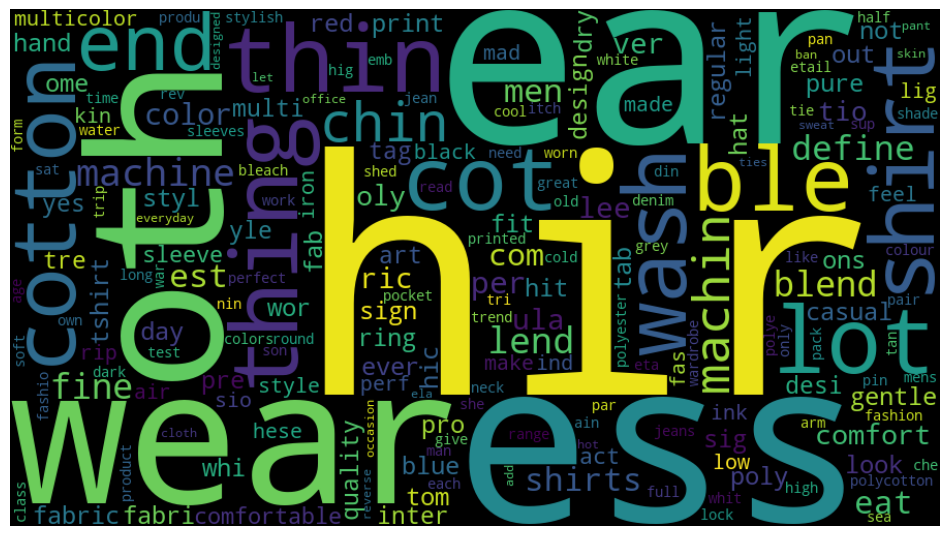

In [ ]:
# Criação da nuvem de palavras
# Converte o dataframe em um dicionário de palavras e frequências
word_freq = {row['palavra']: row['qtd'] for index, row in dfPalavras.iterrows()}

# Cria a nuvem de palavras
wordcloud = WordCloud(width=800, height=500, background_color='black').generate_from_frequencies(word_freq)

# Plotar a nuvem de palavras
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Não mostra os eixos para melhor visualização
plt.show()

<a id='3'></a>
# 3. EDA - Análise Exploratória

## 3.1 Analise Univariada

In [ ]:
#Separar dataframe em numerico e categorico
numerical_feat = df1.select_dtypes(include=['float','int'])
categorical_feat = df1.select_dtypes(exclude=['float','int','datetime'])

In [ ]:
numerical_feat.hist(bins=50, figsize=(12,9));

In [ ]:
columns_to_plot = numerical_feat.columns

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 12))
fig.subplots_adjust(hspace=0.5)

#Usar o divmod para encontrar os axes 
for i, column in enumerate(columns_to_plot):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    #plotar todos os boxplots
    sns.boxplot(df1, x=column, ax=ax)
    ax.set_title(column)

plt.show()

## 3.2 Analise Bivariada

In [ ]:
plt.figure(figsize=(9,12))

#Category
plt.subplot(2,1,1)
sns.barplot(df1, x='category', y='actual_price')
plt.title('Preço Médio por Categoria')
plt.xlabel("Categoria")
plt.ylabel("Preço")

#Subcategory
plt.subplot(2,1,2)
sns.barplot(df1, x='actual_price', y='sub_category', orient='horizontal')
plt.title('Preço Médio por Subcategoria')
plt.xlabel("Preço")
plt.ylabel("Sub Categoria")


plt.tight_layout()

In [ ]:
plt.figure(figsize=(12,7))

# Sub Category vendas
plt.subplot(1,2,1)
top5_subcat = df1['sub_category'].value_counts().iloc[:5]
top5_subcat = pd.DataFrame(top5_subcat).reset_index()
top5_subcat.columns = ['sub_category', 'count']
sns.barplot(data=top5_subcat, x='count', y='sub_category', orient='horizontal')
plt.title("Nº Vendas por Sub Categoria")

# Category Vendas
plt.subplot(1,2,2)
top3_cat = df1['category'].value_counts()
top3_cat = pd.DataFrame(top3_cat).reset_index()
top3_cat.columns = ['category', 'count']
sns.barplot(data=top3_cat, x='count', y='category', orient='horizontal')
plt.title("Nº Vendas por Categoria")

plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(12,6))

#top 10 Brands
plt.subplot(1,2,1)
top10_brands = df1['brand'].value_counts().iloc[:10].index
top_df = df1.loc[df1['brand'].isin(top10_brands),:]
sns.barplot(top_df, y='brand', x='actual_price', orient='horizontal')
plt.title("Top 10 Marcas Mais Vendidas")
plt.xlabel("Nº vendas")
plt.ylabel("Vendedor")

#top 10 Sellers
plt.subplot(1,2,2)
top10_seller = df1['seller'].value_counts().iloc[:10].index
top_df_seller = df1.loc[df1['seller'].isin(top10_seller),:]
sns.barplot(top_df_seller, y='seller', x='actual_price', orient='horizontal')
plt.title("Top 10 Vendedores")
plt.xlabel("Nº Vendas")
plt.ylabel("Vendedor")

plt.tight_layout()

In [ ]:
plt.figure(figsize=(12,9))

#Plotor todos os tipos de tecidos e Sizes
plt.subplot(2,3,1)
sns.barplot(df1, y='actual_price', x='has_polyester')

plt.subplot(2,3,2)
sns.barplot(df1, y='actual_price', x='has_cotton')

plt.subplot(2,3,3)
sns.barplot(df1, y='actual_price', x='has_lycra')

plt.subplot(2,3,4)
sns.barplot(df1, y='actual_price', x='is_slim')

plt.subplot(2,3,5)
sns.barplot(df1, y='actual_price', x='is_regular')

plt.subplot(2,3,6)
sns.barplot(df1, y='actual_price', x='is_fit')

In [ ]:
#Origem de fabricação da roupa
sns.barplot(df1, y='COUNTRY OF ORIGIN', x='actual_price', orient='horizontal')
plt.title("Preço por País de Origem")
plt.xlabel("Preço")
plt.ylabel("País de Origem")


## 3.3 Análise Multivariada

In [ ]:
#Correlação Numéricas
plt.figure(figsize=(10,5))
sns.heatmap(numerical_feat.corr(), annot=True, fmt='.2f', cmap='BrBG')
plt.title("Matriz de Correlação Variáveis Numéricas")

In [ ]:
#Selecionar categóricas para usar no função CRAMER'S V
df_cramer = df1.loc[:,['brand',
                       'category',
                       'sub_category',
                       'actual_price', 
                       'TYPE',
                       'seller',
                       'FABRIC CARE', 
                       'STYLE CODE']]

num_vars = len(df_cramer.columns)
correlation_matrix = np.zeros((num_vars, num_vars))

In [ ]:
#Aplicar o Cramer's V para criar matriz de correlação
for i in range(num_vars):
    for j in range(num_vars):
        if i != j:
            corr = cramers_v(df_cramer.iloc[:, i], df_cramer.iloc[:, j])
            correlation_matrix[i, j] = corr

In [ ]:
plt.figure(figsize=(10,5))

correlation_df = pd.DataFrame(correlation_matrix, columns=df_cramer.columns, index=df_cramer.columns)
sns.heatmap(correlation_df.corr(), annot=True, fmt='.2f', cmap='BrBG')
plt.title("Correlação Variáveis Categóricas");

## 3.4 Hipóteses

### Relação entre Média de Avaliação e Preço

H1 - Produtos com um maior número de avaliações têm mais vendas e, portanto, preços mais elevados. (Resultado: FALSO)

In [ ]:
plt.figure(figsize=(15, 9))  

#Number of Reviews
plt.subplot(2, 2, 1) 
sns.scatterplot(data=df1.loc[df1['number_of_reviews'] > 0,:], x='number_of_reviews', y='actual_price')
plt.title('Número de Avaliações e Preço')
plt.xlabel("Número De Avaliações")
plt.ylabel("Preço")

plt.subplot(2, 2, 2)  
sns.heatmap(df1.loc[df1['number_of_reviews'] > 0,['number_of_reviews', 'actual_price']].corr(), annot=True, cmap='BrBG')
plt.title('Correlação')

#--------------------------------------------------------------#

#Average Rating
plt.subplot(2, 2, 3) 
sns.scatterplot(data=df1.loc[df1['average_rating'] > 0,:], x='average_rating', y='actual_price')
plt.title('Média de Avaliações e Preço')
plt.xlabel("Média De Avaliações")
plt.ylabel("Preço")



plt.subplot(2, 2, 4)  
sns.heatmap(df1.loc[df1['average_rating'] > 0,['average_rating', 'actual_price']].corr(), annot=True, cmap='BrBG')
plt.title('Correlação')

plt.tight_layout()

FALSO. Não temos uma correlação entre Avaliações e Preço.

### Relação entre Detalhes & Número de Imagens e Preço

H2 - Produtos com mais Imagens e detalhes podem ter um preço mais elevado ou vender mais. (Resultado: VERDADEIRO e FALSO)

In [ ]:
plt.figure(figsize=(15, 9))  

#Number Images
plt.subplot(2, 2, 1) 
sns.scatterplot(data=df1, x='number_images', y='actual_price')
plt.title('Número de Imagens e Preço')
plt.xlabel("Número De Imagens")
plt.ylabel("Preço")

plt.subplot(2, 2, 2)  
sns.heatmap(df1[['number_images', 'actual_price']].corr(), annot=True, cmap='BrBG')
plt.title('Correlação')

#-----------------------------------------------------#

#Product Details Count
plt.subplot(2, 2, 3) 
sns.scatterplot(data=df1, x='product_details_count', y='actual_price')
plt.title('Detalhes do Produtos e Preço')
plt.xlabel("Quantidade de Detalhes")
plt.ylabel("Preço")

plt.subplot(2, 2, 4)  
sns.heatmap(df1[['product_details_count', 'actual_price']].corr(), annot=True, cmap='BrBG')
plt.title('Correlação')

plt.tight_layout()

VERDADEIRO. Temos uma Correlação positiva entre número imagens e o preço, indicadando que itens com preços elevados tendem a ter mais fotos e, consequentemente venderem mais.
FALSO. Não se verifica correlação entre detalhes do produto e o preço.

### Relação entre Estoque e Preço

H3 - Produtos que estão fora de estoque podem ser precificados de forma diferente. (Resultado: VERDADEIRO)

In [ ]:
sns.barplot(df1, x='out_of_stock', y='actual_price')
plt.title("Relação entre Estoque e Preço")
plt.xlabel("Fora de Estoque")
plt.ylabel("Preço")

VERDADEIRO. Vemos um ligeira diferença entre Produtos em estoque e sem. Pode ser uma estrategia da empresa aumentar os preços de produtos fora de estoque até esse estoque ser renovado.

<a id='4'></a>
# 4. PRÉ-PROCESSAMENTO

## 4.0 Preparação da base

In [ ]:
cols_drop = ['_id','crawled_at','description','title']
df1 = df1.drop(cols_drop, axis=1)

#aplicar inflection para renomear colunas
df1.columns = df1.columns.map(lambda x: inflection.parameterize(x, separator='_'))

In [ ]:
X = df1.drop(['pid','actual_price'], axis=1).copy()
y = df1['actual_price'].copy()

In [ ]:
#20% validação e 80% treino
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## 4.1 One-Hot Encoding

In [ ]:
X_train['category'].value_counts()

In [ ]:
X_train['category'].unique()

In [ ]:
#One Hot Encoding
#onehot = ['category']
onehot = ['category','out_of_stock']
X_train = pd.get_dummies(X_train, columns=onehot)
X_val = pd.get_dummies(X_val, columns=onehot)
X = pd.get_dummies(X, columns=onehot)

#Renomear as colunas criadas pelo OneHot Encoding
X_train.columns = X_train.columns.map(lambda x: inflection.parameterize(x, separator='_'))
X_val.columns = X_val.columns.map(lambda x: inflection.parameterize(x, separator='_'))
X.columns = X.columns.map(lambda x: inflection.parameterize(x, separator='_'))

In [ ]:
X_train.shape, X_val.shape

## 4.2 Target Encoding

In [ ]:
# Target Encoding (para as features do tipo string)
te_cols = ['brand','seller','sub_category',"fabric",
                        "brand_color",
                        "closure",
                        "other_details",
                        "sales_package",
                        "sleeve_type",
                        "model_name",
                        "fabric_care",
                        "hooded",
                        "pockets",
                        "pack_of",
                        "number_of_contents_in_sales_package",
                        "number_of_contents_str",
                        "secondary_color",
                        "style_code",
                        "ideal_for",
                        "reversible",
                        "neck",
                        "generic_name",
                        "brand_fit",
                        "pattern",
                        "sleeve",
                        "country_of_origin",
                        "size",
                        "fit",
                        "suitable_for",
                        "occasion",
                        "color",
                        "neck_type",
                        "type"]

#Tranformar as categorias em strings para aplicar Target Encoding
X_train[te_cols] = X_train[te_cols].astype(str)
X_val[te_cols] = X_val[te_cols].astype(str)
X[te_cols] = X[te_cols].astype(str)

#Criar Target Encoding
te = TargetEncoder(target_type='continuous')

#Aplicar fit_transform no X_train
X_train[te_cols] = te.fit_transform(X_train[te_cols], y_train)

#Transform nos outros
X_val[te_cols] = te.transform(X_val[te_cols])
X[te_cols] = te.transform(X[te_cols])

In [ ]:
X_train.sample(4).T

## 4.3 K-Means

In [ ]:
# Monta primeira clusterização com: ['brand', 'sub_category', 'type']
features = ['brand', 'sub_category', 'type']
ret = kmeans_fit( X, features, 14, 18 )

model_kmeans1 = ret[0]
ss = ret[1]

# Monta a variável KMEANS e inclui em X
X['kmeans'] = model_kmeans1.labels_

#INCLUI EM X_train e X_val
X_kmeans_train = X_train.loc[ :, features]
X_train['kmeans'] = model_kmeans1.predict( X_kmeans_train )

X_kmeans_val = X_val.loc[ :, features]
X_val['kmeans'] = model_kmeans1.predict( X_kmeans_val )

In [ ]:
# Monta segunda clusterização com: ['average_rating', 'brand_fit', 'sleeve']
features = ['average_rating', 'brand_fit', 'sleeve']
ret = kmeans_fit( X, features, 14, 21 )

model_kmeans2 = ret[0]
ss2 = ret[1]

# Monta a variável KMEANS e inclui em X
X['kmeans2'] = model_kmeans2.labels_

#INCLUI EM X_train e X_val
X_kmeans_train = X_train.loc[ :, features]
X_train['kmeans2'] = model_kmeans2.predict( X_kmeans_train )

X_kmeans_val = X_val.loc[ :, features]
X_val['kmeans2'] = model_kmeans2.predict( X_kmeans_val )

In [ ]:
# Monta terceira clusterização com: ['number_of_contents_in_sales_package', 'neck', 'average_rating']
# OBS: possivelmente incluir também 'secondary_color'

features = ['number_of_contents_in_sales_package', 'neck', 'average_rating']
ret = kmeans_fit( X, features, 25, 35 )

model_kmeans3 = ret[0]
ss3 = ret[1]

# Monta a variável KMEANS e inclui em X
X['kmeans3'] = model_kmeans3.labels_

#INCLUI EM X_train e X_val
X_kmeans_train = X_train.loc[ :, features]
X_train['kmeans3'] = model_kmeans3.predict( X_kmeans_train )

X_kmeans_val = X_val.loc[ :, features]
X_val['kmeans3'] = model_kmeans3.predict( X_kmeans_val )

## 4.4 Transformação em Log

In [ ]:
plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
sns.histplot(df1['actual_price'], kde=True, bins=25)

plt.subplot(1,2,2)
sns.histplot(np.log1p(df1['actual_price']), kde=True, bins=25)

In [ ]:
#normalizar y
y = np.log1p( y )
y_train = np.log1p( y_train )
y_val = np.log1p( y_val )

## 4.5 Feature Importance

In [ ]:
#Juntar X_train e X_val normalizados
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])

In [ ]:
# Observar se alguma feature permanece com string
X_full.sample(5).T

In [ ]:
# Modelo Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=1) 

# Treinamento
rf.fit(X_full, y_full)

# Obtenha a importância das características
feature_importance = rf.feature_importances_

# DataFrame para facilitar a visualização
feature_importance_df = pd.DataFrame({'Feature': X_full.columns, 'Importance': feature_importance})

# Características com base na importância
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Gráfico de barras
plt.figure(figsize=(12, 9))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importância da Característica')
plt.ylabel('Característica')
plt.title('Importância das Características - Random Forest')
plt.show()

In [ ]:
linhas = feature_importance_df['Importance'] > 0.0030
feature_importance_df2 = feature_importance_df.loc[linhas, :].copy()
#Gráfico de barras
plt.figure(figsize=(5, 7))
plt.barh(feature_importance_df2['Feature'], feature_importance_df2['Importance'])
plt.xlabel('Importância da Característica')
plt.ylabel('Característica')
plt.title('Importância das Características - Random Forest')
plt.show()


<a id='5'></a>
# 5. MACHINE LEARNING

## 5.0 First Trial

### Regressão Linear

In [ ]:
#Instaciar modelo
lr = LinearRegression()

#FIT PREDICT
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)

In [ ]:
lr_metrics = compute_metrics('LinearRegression', y_pred_lr, y_val)
lr_metrics

### XGBoost

In [ ]:
#Instaciar modelo
xgb = XGBRegressor()

#FIT PREDICT
xgb.fit(X_train, y_train)
y_pred_val = xgb.predict(X_val)

In [ ]:
xgb_metrics = compute_metrics('XGBoost', y_pred_val, y_val)
xgb_metrics

### Catboost

In [ ]:
#Instaciar modelo
cat = CatBoostRegressor(verbose=False)

#FIT PREDICT
cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_val)

In [ ]:
cat_metrics = compute_metrics('CatBoost',y_pred_cat, y_val)
cat_metrics

### LightGBM

In [ ]:
#Instaciar modelo
lgb = LGBMRegressor()

#FIT PREDICT
lgb.fit(X_train, y_train)
y_pred_lgb = lgb.predict(X_val)

In [ ]:
lgb_metrics = compute_metrics('LightGBM',y_pred_lgb, y_val)
lgb_metrics

### Random Forest

In [ ]:
#Instaciar modelo
rf = RandomForestRegressor(n_jobs=-1, random_state=58)

#FIT PREDICT
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

In [ ]:
rf_metrics = compute_metrics('RandomForest',y_pred_rf, y_val)
rf_metrics

### Ensemble

In [ ]:
#Instaciar modelo
voting_reg = VotingRegressor(
    estimators=[
        ('random_forest', rf),
        ('catboost', cat),
        ('xgboost', xgb),
        ('lighgbm', lgb),
        
    ]
)

#FIT PREDICT
voting_reg.fit(X_train, y_train)
y_pred_vot = voting_reg.predict(X_val)

#Calcular Metricas
ensenble_metrics = compute_metrics('VotingRegressor', y_pred_vot, y_val)
ensenble_metrics

### Resumo das métricas obtidas

In [ ]:
#Juntar todas as metricas
pd.concat([xgb_metrics, lgb_metrics, cat_metrics, rf_metrics, ensenble_metrics, lr_metrics]).sort_values(by='SMAPE').reset_index(drop=True)

In [ ]:
#Parametros usados na random forest
rf.get_params()

## 5.1 Fine Tuning

In [ ]:
#Definir função objetivo do Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 980, 1000, 1),
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        
    }
    #Random Forest com os parâmetros otimizados
    model = RandomForestRegressor(**params, n_jobs=-1, random_state=58)

    #FIT PREDICT
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    #SMAPE
    smape_error = smape(np.expm1(y_pred), np.expm1(y_val))
    
    return smape_error

In [ ]:
study = optuna.create_study(direction='minimize')

study.optimize(objective, n_trials=20)

In [ ]:
#Melhores Parametros
optuna_best = study.best_params
optuna_best

In [ ]:
fig = optuna.visualization.plot_slice(study)
fig.update_layout(template='plotly_dark', title='<b>Slice Plot', title_x=0.2)

In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(template='plotly_dark', title='<b>Optimization History Plot', title_x=0.5)

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(template='plotly_dark', title='<b>Hyperparameter Importances', title_x=0.5)

<a id='6'></a>
# 6. PREVISÃO TESTE

## 6.1 Prepara para submissão

In [ ]:
#Modelo Otimizado
n_est = optuna_best.get('n_estimators')
rf = RandomForestRegressor(n_jobs=-1, random_state=58, n_estimators=n_est )
n_est

In [ ]:
rf.fit(X_full, y_full)

In [ ]:
#Ler teste
path = 'http://menezes.mendonca.nom.br/datasets/hackday6_cds/test.json'
X_test_2 = pd.read_json(path, orient='split')

In [ ]:
#Limpar teste
X_test_2 = clean_test(X_test_2, onehot, te, X_full )

In [ ]:
# Inclui KMEANS em X_test_2
X_kmeans1 = X_test_2.loc[ :, ['brand', 'sub_category', 'type'] ]
X_test_2['kmeans'] = model_kmeans1.predict( X_kmeans1 )

# Inclui 2º KMEANS
X_kmeans2 = X_test_2.loc[ :, ['average_rating', 'brand_fit', 'sleeve'] ]
X_test_2['kmeans2'] = model_kmeans2.predict( X_kmeans2 )

# Inclui 3º KMEANS
X_kmeans3 = X_test_2.loc[ :, ['number_of_contents_in_sales_package', 'neck', 'average_rating'] ]
X_test_2['kmeans3'] = model_kmeans3.predict( X_kmeans3 )

In [ ]:
#PREDITC
y_pred_test = rf.predict(X_test_2)
y_pred_test = np.expm1(y_pred_test)

## 6.2 Submissão

In [ ]:
df_submission = make_submission(X_test_2, y_pred_test)
df_submission

In [ ]:
df_submission.to_csv('submission_file.csv', index=False)

<a id='7'></a>
# 7. PERFORMANCE DE NEGÓCIO

---

## Premissas

- Vamos considerar uma loja que vende um único produto: Jaquetas de Couro.
- O custo total de cada jaqueta é de R\\$100,00.
- Após a análise de elasticidade de preço, a loja decide que o preço ideal de venda é de R\\$150,00.

## Sem a Otimização do Modelo

- Suponhamos que a loja tenha estabelecido um preço de venda de R\\$150,00 para suas jaquetas de couro.
- Sob essa precificação, a loja vende 1.000 unidades da jaqueta, totalizando R\\$150.000,00 em receita.
- O lucro resultante é de R\\$50.000,00 (R\\$150.000,00 - R$100.000,00 em custos).

## Com o Modelo

Agora, vamos introduzir a otimização de preços com base em um modelo.

- O modelo analisou a base de dados histórica e concluiu que o preço ideal para as jaquetas deveria ser de R\\$200,00.
- Com uma margem de erro de 10% (baseada no treinamento do modelo), a loja pode confiantemente definir o preço em R\\$200,00.
- Como resultado, as vendas não diminuirão significativamente; suponhamos que a loja venda cerca de 900 jaquetas a esse preço.
- O lucro resultante é de R\\$90.000,00 (R\\$180.000,00 - R$90.000,00 em custos), um aumento substancial(80%) em relação à precificação anterior.
  
### Comparação de Cenários:

Sem a otimização do modelo: Receita de R\\$150.000,00 e lucro de R\\$50.000,00.
Com o modelo de otimização: Receita de R\\$180.000,00 e lucro de R\\$90.000,00.


---

<a id='8'></a>
# 8. PRÓXIMOS PASSOS

- Implantar otimização do estoque com base no modelo de previsão de preços.
- Aprimorar a etapa de Feature Engineering
- Implementar técnicas de redução de dimensionalidade, tais como: Principal Component Analysis (PCA), Locally Linear Embedding (LLE) ou Autoencoders.